In [1]:
import re
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import Word
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from wordcloud import WordCloud


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gtp43728\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gtp43728\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data_folder = "./bbc"
folders = ["business","entertainment","politics","sport","tech"]

os.chdir(data_folder)
news= pd.DataFrame(columns=['content','class'])
for i in folders:
    files = os.listdir(i)
    for text_file in files:
        file_path = i + "/" + text_file
       
        with open(file_path,'r') as f:
            data = f.read().replace('\n\n', '. ')
            news=news.append({'content': data, 'class': i}, ignore_index=True)
     
news.head()

,content,class
0,Ad sales boost Time Warner profit. Quarterly p...,business
1,Dollar gains on Greenspan speech. The dollar h...,business
2,Yukos unit buyer faces loan claim. The owners ...,business
3,High fuel prices hit BA's profits. British Air...,business
4,Pernod takeover talk lifts Domecq. Shares in U...,business


In [3]:
def clean_str(string):
    """
    Tokenization/string cleaning for datasets.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"\'s", "", string)
    string = re.sub(r"\'ve", "", string)
    string = re.sub(r"n\'t", "", string)
    string = re.sub(r"\'re", "", string)
    string = re.sub(r"\'d", "", string)
    string = re.sub(r"\'ll", "", string)
    string = re.sub(r",", "", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", "", string)
    string = re.sub(r"\)", "", string)
    string = re.sub(r"\?", "", string)
    string = re.sub(r"'", "", string)
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"[0-9]\w+|[0-9]","", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()
news['cleaned'] = news['content'].apply(lambda x: clean_str(x))

In [4]:
news.head()

,content,class,cleaned
0,Ad sales boost Time Warner profit. Quarterly p...,business,ad sales boost time warner profit quarterly pr...
1,Dollar gains on Greenspan speech. The dollar h...,business,dollar gains on greenspan speech the dollar ha...
2,Yukos unit buyer faces loan claim. The owners ...,business,yukos unit buyer faces loan claim the owners o...
3,High fuel prices hit BA's profits. British Air...,business,high fuel prices hit ba profits british airway...
4,Pernod takeover talk lifts Domecq. Shares in U...,business,pernod takeover talk lifts domecq shares in uk...


*Bài toán phân cụm, dữ liệu lớn --> sử dụng KMeans*

In [5]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95,stop_words="english")

X = vectorizer.fit_transform(news['cleaned'])

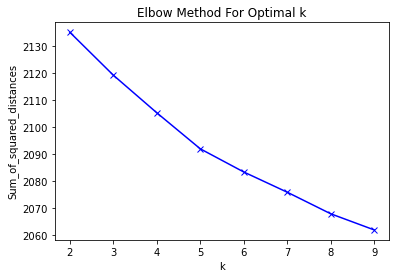

In [6]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10)
   km = km.fit(X)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

*Có tổng cộng 5 cụm, phân chia mẫu tin tức theo cụm như bảng bên trên*

In [7]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)

kmeans.fit(X)

clusters = kmeans.labels_
news['cluster'] = clusters

In [8]:
news

,content,class,cleaned,cluster
0,Ad sales boost Time Warner profit. Quarterly p...,business,ad sales boost time warner profit quarterly pr...,2
1,Dollar gains on Greenspan speech. The dollar h...,business,dollar gains on greenspan speech the dollar ha...,2
2,Yukos unit buyer faces loan claim. The owners ...,business,yukos unit buyer faces loan claim the owners o...,2
3,High fuel prices hit BA's profits. British Air...,business,high fuel prices hit ba profits british airway...,2
4,Pernod takeover talk lifts Domecq. Shares in U...,business,pernod takeover talk lifts domecq shares in uk...,2
...,...,...,...,...
2220,BT program to beat dialler scams. BT is introd...,tech,bt program to beat dialler scams bt is introdu...,1
2221,Spam e-mails tempt net shoppers. Computer user...,tech,spam e mails tempt net shoppers computer users...,1
2222,Be careful how you code. A new European direct...,tech,be careful how you code a new european directi...,1
2223,US cyber security chief resigns. The man makin...,tech,us cyber security chief resigns the man making...,1


*Keywwords của mỗi cụm và WordClouds cho từng cụm*

In [9]:
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names() # access tf-idf terms
    a=pd.DataFrame(columns=['Cluster','Words'])
    for i,r in df.iterrows():
        a=a.append({'Cluster': i, 'Words': [terms[t] for t in np.argsort(r)[-n_terms:]]}, ignore_index=True)
        
    a['Words'] = a['Words'].apply(lambda x: ' '.join(map(str, x)))
    return a      
keywords=get_top_keywords(15)
keywords

,Cluster,Words
0,0,final club time coach injury season play playe...
1,1,new using online phone internet net computer u...
2,2,prices analysts mr sales oil economic bank sha...
3,3,oscar album singer films band tv actor year mu...
4,4,brown leader tories secretary prime tory peopl...


Cluster: 0
Class: sport


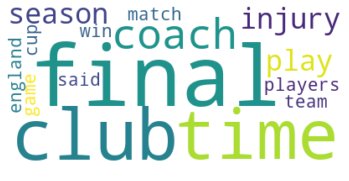

Cluster: 1
Class: tech


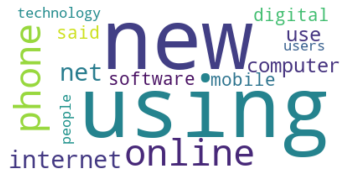

Cluster: 2
Class: business


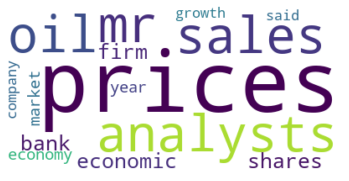

Cluster: 3
Class: entertainment


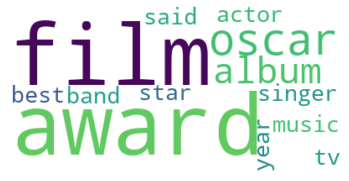

Cluster: 4
Class: politics


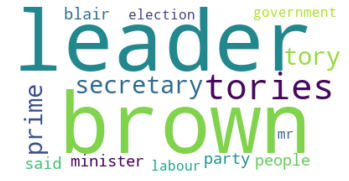

In [10]:
result=keywords
title=["sport","tech","business","entertainment","politics"]
for k in range(0,5):
   s=result[result.Cluster==k]
   text=result.Words[k]
   wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(text)
   print('Cluster: {}'.format(k))
   print('Class: {}'.format(title[k]))
           
  
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()

*Kiểm tra lại với mẫu số 1000*

In [11]:
news.loc[999,['class','cluster']]

class      politics
cluster           4
Name: 999, dtype: object

In [12]:
x = vectorizer.transform([news['cleaned'][999]])
y=kmeans.predict(x)
print("Cluster:", y)

Cluster: [4]
